In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

In [2]:
import torch
print(torch.__version__)

1.10.2+cu102


(128, 128)


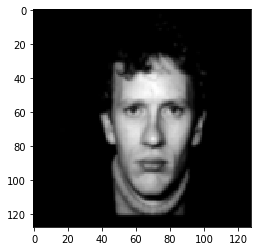

84


In [3]:
# 查看单个图片信息
# 2099-2106 全黑
f = open('./face/rawdata/2155','rb')
x = np.fromfile(f,dtype=np.ubyte)
x = x.reshape(128,-1)
# x = x[:,:500]
print(x.shape)
plt.imshow(x,cmap=plt.cm.gray)
plt.show()
f.close()
print(x[50,50])

In [4]:
all_file = os.listdir('./face/rawdata')
len(all_file)
all_file[876]


'2110'

In [5]:
# 读取所有data_x数据,  有问题的数据：第1186个，2412号；第1190个，2416号
data_x = np.zeros((len(all_file),128,128))
data_y = np.zeros(len(all_file))


In [6]:
# 将两个数据标签整理再一起
f = open('./face/faceDR','r')
r1 = f.readlines()
f.close()

f = open('./face/faceDS','r')
r2 = f.readlines()
f.close()
for i in r2:
    r1.append(i)

In [7]:
# 整理出data_x,和data_y
all_file = os.listdir('./face/rawdata')
for i in range(len(all_file)):
    with open('./face/rawdata/'+all_file[i],'rb') as f:
        x = np.fromfile(f,dtype=np.ubyte)
        x = x.reshape(128,-1)
        data_x[i] = x
        for j in r1:
            if all_file[i] in j:
                if 'female' in j:
                    data_y[i] = 0
                elif 'male' in j:
                    data_y[i] = 1
                else:
                    data_y[i] = None
                break

        # print(i)
        # if i==1186 or i== 1190:
        #     pass
        # else:
        #     data_x[i] = x


In [8]:
data_y.shape

(3983,)

In [8]:
from sklearn.preprocessing import OneHotEncoder
data_y = data_y.reshape(-1,1)
enc = OneHotEncoder(categories='auto').fit(data_y)
data_y = enc.transform(data_y).toarray()
data_y.shape

d:\Study softwares\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_int = np.zeros((n_samples, n_features), dtype=np.int)
d:\Study softwares\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for

(3983, 2)

In [9]:
data_y[:2]

array([[0., 1.],
       [0., 1.]])

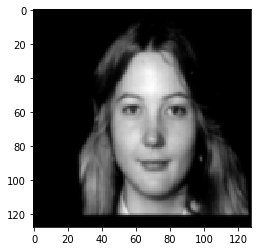

gender: [1. 0.]


In [9]:
# 查看数据集其中的图片和标签，1表示男，0表示女
# i = 876  有点问题
i = 1367
x = data_x[i]
y = data_y[i]
plt.imshow(x,cmap=plt.cm.gray)
plt.show()
print("gender:",y)

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import ssl
from torch import nn,optim
ssl._create_default_https_context = ssl._create_unverified_context

d:\Study softwares\Anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [11]:
from torch.nn import functional as F

# ResNet要加BatchNorm2d
class ResBlk(nn.Module):
    def __init__(self,ch_in,ch_out,stride=1):
        ch_s = int(ch_out/4)
        super(ResBlk,self).__init__()
        self.conv1 = nn.Conv2d(ch_in,ch_s,kernel_size=1,stride=1,padding=0)
        self.bn1 = nn.BatchNorm2d(ch_s)
        self.conv2 = nn.Conv2d(ch_s,ch_s,kernel_size=3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(ch_s)
        self.conv3 = nn.Conv2d(ch_s,ch_out,kernel_size=1,stride=1,padding=0)
        self.bn3 = nn.BatchNorm2d(ch_out)

        self.extra = nn.Sequential()
        if ch_out != ch_in:
            self.extra = nn.Sequential(
                nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1),
                nn.BatchNorm2d(ch_out)
                # ,nn.ReLU()
            )

    def forward(self,x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.relu(self.bn3(self.conv3(out)))
        # print("----")
        # print(out.shape)
        # print(self.extra(x).shape)
        out = self.extra(x)+out
        return out

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet,self).__init__()

        self.conv1 =nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1)
            ,nn.BatchNorm2d(32)
            ,nn.ReLU()
            ,nn.MaxPool2d(kernel_size=2,stride=2)
        )
        # [b,32,64,64]->[b,64,32,32]
        self.blk1 = ResBlk(32,64,stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        # [b,64,32,32]->[b,128,16,16]
        self.blk2 = ResBlk(64,128,stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        # [b,128,16,16]->[b,256,8,8]
        self.blk3 = ResBlk(128,256,stride=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=2)
        # # [b,256,8,8]->[b,256,4,4]
        self.blk4 = ResBlk(256,256,stride=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2,stride=2)

        self.flayer = nn.Linear(4096,128)
        self.outlayer = nn.Linear(128,2)

    def forward(self,x):
        out = self.conv1(x)
        out = self.blk1(out)
        out = self.pool1(out)
        out = self.blk2(out)
        out = self.pool2(out)
        out = self.blk3(out)
        out = self.pool3(out)
        out = self.blk4(out)
        out = self.pool4(out)
        # print('after conv:',out.shape)
        # x = F.adaptive_avg_pool2d(x,[1,1])
        # print('after pool:',x.shape)
        out= out.view(out.size(0),-1)
        out = self.flayer(out)
        out = self.outlayer(out)

        return out


In [12]:
torch.set_default_tensor_type(torch.DoubleTensor)

In [13]:
# 分数据集
data_x = data_x.reshape(-1,1,128,128)
data_x.shape

# 打乱数据集
state = np.random.get_state()
np.random.shuffle(data_x)
np.random.set_state(state)
np.random.shuffle(data_y)

X = torch.from_numpy(data_x)
Y = torch.from_numpy(data_y)

In [94]:

# state = np.random.get_state()
# np.random.shuffle(X)

# np.random.set_state(state)
# np.random.shuffle(Y)

data_set = []
for i in range(len(Y)):
    data_set.append((X[i],Y[i]))

In [95]:
train_set,test_set = torch.utils.data.random_split(data_set,[3000,983],generator=torch.Generator().manual_seed(0))
print("train_set:",len(train_set),"\ttest_set",len(test_set))

train_set: 3000 	test_set 983


In [18]:
Xtrain,Xtest,Ytrain,Ytest = X[:3000],X[3000:],Y[:3000],Y[3000:]


In [ ]:
train_set = []
for i in range(len(Ytrain)):
    train_set.append((Xtrain[i],Ytrain[i]))
test_set =[]
for i in range(len(Ytest)):
    test_set.append((Xtest[i],Ytest[i]))

In [96]:
batch_size = 16

set_train = torch.utils.data.DataLoader(train_set,batch_size = batch_size,shuffle=True)
set_test = torch.utils.data.DataLoader(test_set,batch_size = batch_size,shuffle=False)

In [97]:
loss_list = []
acc_list = []

In [98]:
import time
x,label = iter(set_train).next()
# print('x:',x.shape,'label:',label.shape)

device = torch.device('cuda')
# 加载
net = ResNet()
net = net.to(device)
net.load_state_dict(torch.load('ResNet_face.mdl'))

criteon = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(net.parameters(),lr=1e-3)

# print(net)
print("---------")
epochs = 2
# print("First fold Cross-Validation:")
t1 = time.time()
for epoch in range(epochs):
    
    for batchidx,(x,label) in enumerate(set_train):
        # x:[b,1,128,128]
        # label [b,2]
        x,label = x.to(device),label.to(device)
        logits = net(x)
        # loss: tensor scalar
        # print("----------")
        # print(logits.shape)
        # print(label.shape)
        loss = criteon(logits,label)

        # backprop
        optimizer.zero_grad() # 优化器清零
        loss.backward()
        optimizer.step() # 更新

    print("Epoch {},Value of Loss function:{}".format(epoch,loss.item()))
    loss_list.append(loss.item())
    
    net.eval()
    # 不需要构建计算图
    with torch.no_grad():
        # test
        total_correct = 0
        total_num = 0
        for x,label in set_test:
            x , label = x.to(device),label.to(device)
            logits = net(x)
            pred = logits.argmax(dim=1)
            # print(pred)
            total_correct += torch.eq(pred,label.argmax(dim=1)).float().sum().item()
            total_num += x.size(0)

        acc = total_correct /total_num
        
        print("\tAccuracy:{}".format(acc))
        # kcv.append((loss.item(),acc))
        
        # acc_list.append(acc)
print("\tMean Run Time / Epoch:{:.4f}s ".format((time.time()-t1)/epochs))

torch.save(net.state_dict(),'ResNet_face.mdl')

---------
Epoch 0,Value of Loss function:0.05028462432563988
	Accuracy:0.9664292980671414
Epoch 1,Value of Loss function:0.07687932406670206
	Accuracy:0.9542217700915565
	Mean Run Time / Epoch:107.4476s 


In [87]:
print("\tMean Run Time / Epoch:{:.4f}s ".format(acc))
torch.save(net.state_dict(),'ResNet_face.mdl')

	Mean Run Time / Epoch:0.8500s 


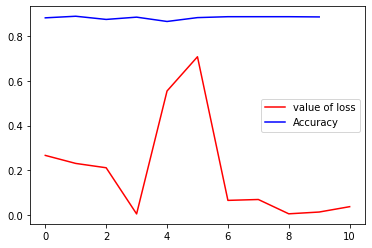

Final Accuracy: 0.8861%
The Highest Accuracy: 0.8891%


In [60]:
plt.plot(range(len(loss_list)),loss_list,"r-",label = "value of loss")
plt.plot(range(len(acc_list)),acc_list,"b-",label="Accuracy")
plt.legend()
plt.show()
print("Final Accuracy: {:.4f}%".format(acc_list[-1]))
print("The Highest Accuracy: {:.4f}%".format(max(acc_list)))

In [55]:
print(loss_list)

[]


#### 交叉验证 

In [15]:
# 分数据集
# # First
Xtrain,Xval,Ytrain,Yval = X[:2000],X[2000:3000],Y[:2000],Y[2000:3000]
# second
# Xtrain,Xval,Ytrain,Yval = X[1000:3000],X[:1000],Y[1000:3000],Y[:1000]
# # Third
# Xtrain,Xval,Ytrain,Yval = torch.cat((X[:1000],X[2000:3000]),dim=0),X[1000:2000],torch.cat((Y[:1000],Y[2000:3000]),dim=0),Y[1000:2000]

train_set = []
for i in range(len(Ytrain)):
    train_set.append((Xtrain[i],Ytrain[i]))
val_set =[]
for i in range(len(Yval)):
    val_set.append((Xval[i],Yval[i]))
batch_size = 16
# epochs = 10

set_train = torch.utils.data.DataLoader(train_set,batch_size = batch_size,shuffle=True)

set_val = torch.utils.data.DataLoader(val_set,batch_size = batch_size,shuffle=True)

In [16]:
loss_list1 = []
acc_list1 = []
# loss_list2 = []
# acc_list2 = []
# loss_list3 = []
# acc_list3 = []

In [17]:
import time
x,label = iter(set_train).next()
# print('x:',x.shape,'label:',label.shape)

device = torch.device('cuda')
# 加载
net = ResNet()
net = net.to(device)
# net.load_state_dict(torch.load('ResNet_face3.mdl'))

criteon = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(net.parameters(),lr=1e-3)

# print(net)
print("---------")
epochs = 10
print("First fold Cross-Validation:")
# print("Second fold Cross-Validation:")
# print("Third fold Cross-Validation:")
for epoch in range(epochs):
    t1 = time.time()
    for batchidx,(x,label) in enumerate(set_train):
        # x:[b,1,128,128]
        # label [b,2]
        x,label = x.to(device),label.to(device)
        logits = net(x)
        # loss: tensor scalar
        # print("----------")
        # print(logits.shape)
        # print(label.shape)
        loss = criteon(logits,label)

        # backprop
        optimizer.zero_grad() # 优化器清零
        loss.backward()
        optimizer.step() # 更新

    print("Epoch {},Value of Loss function:{}".format(epoch,loss.item()))
    loss_list1.append(loss.item())
    
    net.eval()
    # 不需要构建计算图
    with torch.no_grad():
        # test
        total_correct = 0
        total_num = 0
        for x,label in set_val:
            x , label = x.to(device),label.to(device)
            logits = net(x)
            pred = logits.argmax(dim=1)
            # print(pred)
            total_correct += torch.eq(pred,label.argmax(dim=1)).float().sum().item()
            total_num += x.size(0)

        acc = total_correct /total_num
        
        print("\tAccuracy:{}".format(acc))
        # kcv.append((loss.item(),acc))
        # print("\trun time:{:.4f}s".format(time.time()-t1))
        acc_list1.append(acc)
        
torch.save(net.state_dict(),'ResNet_face1.mdl')
# torch.save(net.state_dict(),'ResNet_face3.mdl')
# torch.save(net.state_dict(),'ResNet_face2.mdl')

---------
First fold Cross-Validation:
Epoch 0,Value of Loss function:0.6820575139220919
	Accuracy:0.672
Epoch 1,Value of Loss function:0.5272165331027173
	Accuracy:0.714
Epoch 2,Value of Loss function:0.4395585387090166
	Accuracy:0.765
Epoch 3,Value of Loss function:0.1737072998031129
	Accuracy:0.787
Epoch 4,Value of Loss function:0.5639205444630149
	Accuracy:0.813
Epoch 5,Value of Loss function:0.2782706342228778
	Accuracy:0.825
Epoch 6,Value of Loss function:0.09320195537039973
	Accuracy:0.835
Epoch 7,Value of Loss function:0.1843404116311786
	Accuracy:0.839
Epoch 8,Value of Loss function:0.2091926611102475
	Accuracy:0.824
Epoch 9,Value of Loss function:0.1527358577055404
	Accuracy:0.85


First fold Cross-Validation:


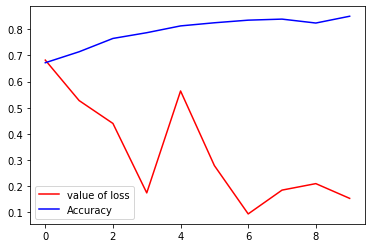

Final Accuracy: 0.8500%
The Highest Accuracy: 0.8500%


In [18]:
plt.plot(range(len(loss_list1)),loss_list1,"r-",label = "value of loss")
plt.plot(range(len(acc_list1)),acc_list1,"b-",label="Accuracy")
print("First fold Cross-Validation:")
# print("Second fold Cross-Validation:")
# print("Third fold Cross-Validation:")
plt.legend()
plt.show()
print("Final Accuracy: {:.4f}%".format(acc_list1[-1]))
print("The Highest Accuracy: {:.4f}%".format(max(acc_list1)))

In [42]:
print("Averagy Accuracy of 3 fold Cross_Validation {:.4f}%".format(100*(0.867+max(acc_list2)+0.872)/3))

Averagy Accuracy of 3 fold Cross_Validation 86.8667%


In [63]:
def plot_image(img,pred,label):
    fig = plt.figure()
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.tight_layout()
        plt.imshow(img[i][0]*0.3081+0.1307,cmap = "gray",interpolation='none')
        if pred[i].item() == 1:
            g = '♂'
        elif pred[i].item() == 0:
            g = "♀"
        else:
            g = 'n'
        if pred[i].item() == label[i].item():
            fact = '√'
        else:
            fact = 'X'

        plt.title("{}:{}({})".format("test",g,fact))
        plt.xticks([])
        plt.yticks([])
    plt.show()

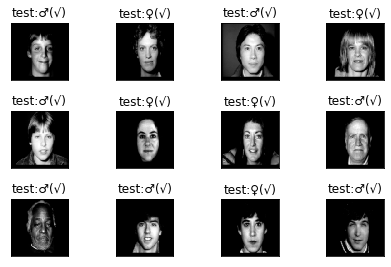

In [64]:
x,label = iter(set_test).next()
x ,label = x.to(device),label.to(device)
out = net(x.view(-1,1,128,128))
pred = out.argmax(dim = 1)
label = label.argmax(dim=1)
plot_image(x.cpu(),pred.cpu(),label)

#### 模型应用和识别展示

torch.Size([1, 128, 128])


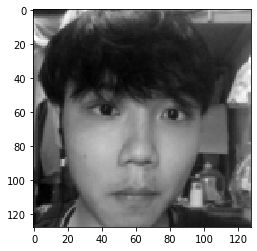

In [120]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


def readImage(path='./face/picture/3.jpg', size=128):
    mode = Image.open(path)
    transform1 = transforms.Compose([
        transforms.Scale(size),
        transforms.CenterCrop((size, size)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])
    mode = transform1(mode)
    return mode


def showTorchImage(image):
    print(image.shape)
    mode = transforms.ToPILImage()(image)
    plt.imshow(mode,cmap=plt.cm.gray)
    plt.show()



mode = readImage(size=128)
showTorchImage(mode)



In [108]:
def plot_image_1(img,pred):
    fig = plt.figure()
    for i in range(1):
        mode = transforms.ToPILImage()(img)
        plt.imshow(mode,cmap=plt.cm.gray)
        # plt.subplot(1,1,i+1)
        # plt.tight_layout()
        # plt.imshow(img[i][0]*0.3081+0.1307,cmap = "gray",interpolation='none')
        if pred[i].item() == 1:
            g = '♂'
        elif pred[i].item() == 0:
            g = "♀"
        else:
            g = 'n'
        plt.title("{}:{}".format("test",g))
        plt.xticks([])
        plt.yticks([])
    plt.show()

tensor([1], device='cuda:0')


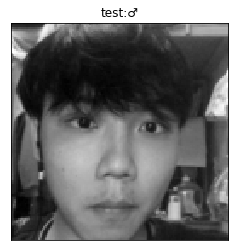

In [121]:
x  = mode.to(device)
out = net(x.view(-1,1,128,128))
pred = out.argmax(dim = 1)
print(pred)
plot_image_1(x.cpu(),pred.cpu())